### Introduction to Data Science - Homework 4
*CS 5963 / MATH 3900, University of Utah, http://datasciencecourse.net/*

Due: Friday, October 7, 11:59pm.

In this homework you will use tools from regression to study house prices in the SLC city zip code 84103. 

## Your Data
Fill out the following information: 

*First Name:*   Tyler 
*Last Name:*   Clive 
*E-mail:*   u0389772@utah.edu 
*UID:* u0389772 


## Part 1: Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in the previous year in zip code 84103 (SLC avenues neighborhod [Google Map](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346]). We are primarily interested in regressing the SoldPrice on the house attributes (property size, house size, number of bedrooms, etc...). 


### Task 1.1 Import the data 
Use the pandas.read_csv() function to import the dataset. The data is contained in two files: 'train1.csv' and 'train2.csv'. After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [45]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [46]:
t1 = pd.read_csv('train1.csv', thousands=',')
t2 = pd.read_csv('train2.csv', thousands=',')

#print(type(housing_data['TotSqf'].values[0]))


#frames = [t1,t2]
#housing_data = pd.concat(frames)
#print(housing_data.shape)

frames = [t1, t2]
housing_data = pd.concat(frames)
print(housing_data.shape)

#The comma in TotSqf interferes with plotting graphs later on, so I remove the comma here:
housing_data['TotSqf'].replace(',','')

(348, 206)


0      5415
1       924
2      1702
3      1756
4       720
5      1368
6      2956
7      1085
8       801
9      1539
10     2113
11     1150
12     1082
13     3387
14     1060
15     5456
16     1211
17     2726
18     1656
19     1000
20      740
21      560
22     2325
23      647
24      944
25     2791
26     1919
27     4581
28     3946
29     2033
       ... 
118    2700
119    4186
120     957
121     667
122    7508
123     693
124     647
125     740
126    2830
127    1006
128    2010
129    6054
130    4530
131    1107
132     892
133    1300
134    1200
135    2080
136    4840
137    2540
138    3017
139    6771
140     770
141     400
142    3494
143    5740
144    1473
145    1385
146    2094
147    2028
Name: TotSqf, dtype: int64

### Task 1.2 Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some of you are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute the value of the house. This is a personal decision - what attributes of a house are important to you? You should at least keep the following variables since the questions below will use them: ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'] 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [str.replace()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lab 9. In particular, convert 'TotSqf' to an integer and add a column titled Prop_Type_num that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
0 & \text{if $i$-th listing is a condo or townhouse} \\
1 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous 'Longitude' (one has Longitude = 0) and 'Taxes' values (two have unreasonably large values).

print(housing_data['TotSqf'].count())

In [47]:
print(housing_data['TotSqf'].count())

# 1. Skim through the variables to get a rough understanding of what the dataset contains.
housing_data.head()


# 2. Filter for houses in my price range
housing_data = housing_data[(housing_data['LstPrice']>=200000) & (housing_data['LstPrice']<=1000000)]


# 3. Remove columns that you don't think contribute to the value of the house
housing_data = housing_data[['ListNo','Acres','Area','Basemnt','City','County','Deck','GaragCap','Garage','HOAFee','Heat','Image','Latitude','Longitude','LstPrice','OpenHseDt','Patio','PkgSpacs','Pool','PropType','Roof','SchDist', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]


# 4. Check the datatypes and convert any numbers that were read as stings to numerical vales.
#print(housing_data.dtypes)
print('right after d-types shape is', housing_data.shape)

    # it seems that all of the columns have the appropriate data type except for 'TotSqf'

housing_data['TotSqf'] = pd.to_numeric(housing_data['TotSqf'], errors='coerce')

print(housing_data.shape)

housing_data = housing_data[(housing_data['Taxes'] > housing_data['LstPrice']*.001) & (housing_data['Taxes'] < housing_data['LstPrice']*.2)]

print("here before the line in question, ",housing_data.shape)

def prop_type_num(each_value):
    if each_value == 'Condo':
        return 0
    
    elif each_value == 'Townhouse':
        return 1
    
    elif each_value == 'Single Family':
        return 2
    
    else:
        return -1

num_series = housing_data['PropType'].map(prop_type_num) 
    
housing_data['Prop_Type_num']=num_series

housing_data = housing_data[(housing_data['Latitude'] > 0.0)]
housing_data = housing_data[(housing_data['Longitude'] < 0.0)]

print(housing_data.shape)

print(housing_data.dtypes)

348
right after d-types shape is (263, 28)
(263, 28)
here before the line in question,  (260, 28)
(259, 29)
ListNo             int64
Acres            float64
Area               int64
Basemnt           object
City              object
County            object
Deck               int64
GaragCap           int64
Garage            object
HOAFee           float64
Heat              object
Image             object
Latitude         float64
Longitude        float64
LstPrice           int64
OpenHseDt         object
Patio              int64
PkgSpacs           int64
Pool              object
PropType          object
Roof              object
SchDist           object
SoldPrice          int64
Taxes              int64
TotBed           float64
TotBth           float64
TotSqf             int64
YearBlt            int64
Prop_Type_num      int64
dtype: object


### Task 1.3 Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the price breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and make a scatter plot matrix to visualize the correlations. For the plot, only use a subset of the columns: ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']. Determine which columns have strong correlations. Write a few (complete) sentences describing your findings. 


In [48]:
housing_data
'''
short description on the dataset:

There are 29 variables and 258 listings. I notice some things about certain variables: Acres - are listed as .01 or 0 
for condos and townhouses; Garage - descriptions not standardized, empty spaces; Garage, HOAFee, Pool, and Heat left 
blank if the house doesnt have them. I think these values are reasonable.'''

'\nshort description on the dataset:\n\nThere are 29 variables and 258 listings. I notice some things about certain variables: Acres - are listed as .01 or 0 \nfor condos and townhouses; Garage - descriptions not standardized, empty spaces; Garage, HOAFee, Pool, and Heat left \nblank if the house doesnt have them. I think these values are reasonable.'

259


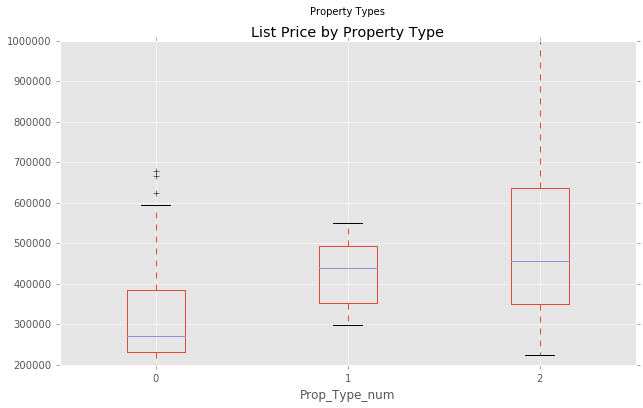

In [49]:
print(housing_data['TotSqf'].count())

#bar chart of price breakdown of different types of houses in zipcode: 84103

#housing_data["LstPrice"].mean()


#DataFrame.groupby(by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False, **kwargs)
#groupby_regiment = df['preTestScore'].groupby(df['company'])
#groupby_regiment


#LstPrice_PropType = housing_data['LstPrice'].groupby(housing_data['Prop_Type_num'])
#list(LstPrice_PropType)

#LstPrice_PropType.mean()
#LstPrice_PropType.describe()

#housing_data.sort()

housing_data.boxplot(column='LstPrice', by='Prop_Type_num', ax=None, fontsize=None, rot=0, grid=True, figsize=None, layout=None, return_type=None)

plt.title("List Price by Property Type")
plt.suptitle("Property Types")

#print(housing_data[['LstPrice']].groupby(['Prop_Type_num']))

In [50]:
# compute the correlation matrix (using all variables)

print(housing_data.corr())

                 ListNo     Acres  Area      Deck  GaragCap    HOAFee  \
ListNo         1.000000 -0.053116   NaN  0.001753 -0.096011 -0.108256   
Acres         -0.053116  1.000000   NaN  0.165592  0.452012 -0.142998   
Area                NaN       NaN   NaN       NaN       NaN       NaN   
Deck           0.001753  0.165592   NaN  1.000000  0.080150 -0.041195   
GaragCap      -0.096011  0.452012   NaN  0.080150  1.000000  0.200857   
HOAFee        -0.108256 -0.142998   NaN -0.041195  0.200857  1.000000   
Latitude       0.016633  0.565449   NaN  0.187892  0.321653  0.133704   
Longitude     -0.057071  0.244949   NaN  0.018158  0.085657 -0.113766   
LstPrice      -0.051331  0.718286   NaN  0.159537  0.636293  0.271115   
Patio          0.042406  0.006796   NaN  0.751318 -0.046339 -0.283651   
PkgSpacs      -0.004763  0.178028   NaN  0.032069 -0.023758 -0.012926   
SoldPrice     -0.033976  0.711851   NaN  0.156301  0.626981  0.264488   
Taxes         -0.105781  0.681925   NaN  0.111933  

              Acres  LstPrice  SoldPrice     Taxes    TotBed    TotBth  \
Acres      1.000000  0.718286   0.711851  0.681925  0.594376  0.508344   
LstPrice   0.718286  1.000000   0.995075  0.882192  0.662400  0.738903   
SoldPrice  0.711851  0.995075   1.000000  0.877505  0.657729  0.726923   
Taxes      0.681925  0.882192   0.877505  1.000000  0.564225  0.729481   
TotBed     0.594376  0.662400   0.657729  0.564225  1.000000  0.602658   
TotBth     0.508344  0.738903   0.726923  0.729481  0.602658  1.000000   
TotSqf     0.741069  0.869683   0.859626  0.818026  0.733040  0.789435   
YearBlt    0.100939  0.189828   0.184861  0.292170 -0.068054  0.302498   

             TotSqf   YearBlt  
Acres      0.741069  0.100939  
LstPrice   0.869683  0.189828  
SoldPrice  0.859626  0.184861  
Taxes      0.818026  0.292170  
TotBed     0.733040 -0.068054  
TotBth     0.789435  0.302498  
TotSqf     1.000000  0.136445  
YearBlt    0.136445  1.000000  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cd85320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12f433668>]], dtype=object)

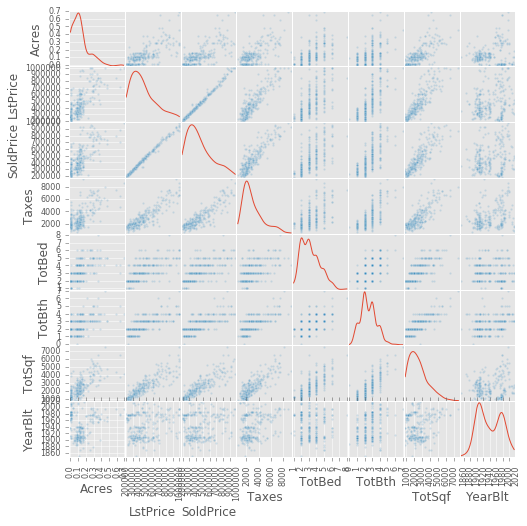

In [51]:
value_indicators = housing_data[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

# computing a correlation matrix with the indicators in the scatter plot matrix
print(value_indicators.corr())

#computing the scatter plot matrix
pd.scatter_matrix(value_indicators, alpha=0.2, figsize=(8, 8), diagonal='kde')

**Your Interpretation:**

As can be seen in the scatter plot matrix (and more easily in the filtered correlation matrix), the key indicators that are most highly correlated with Sold Price are LstPrice (.994), TotSqf (.863), and TotBth (.779). The key indicators with the lowest correlation are Taxes (.120) and YearBlt (.146). 



### Task 1.4 Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

Bonus: If you can, overlay the scatterplot on a map of the city. (This is challenging, and we didn't teach you how to do it, so you might do the other parts of the assignment first.)

What can you say about the relation between the location and the house price?

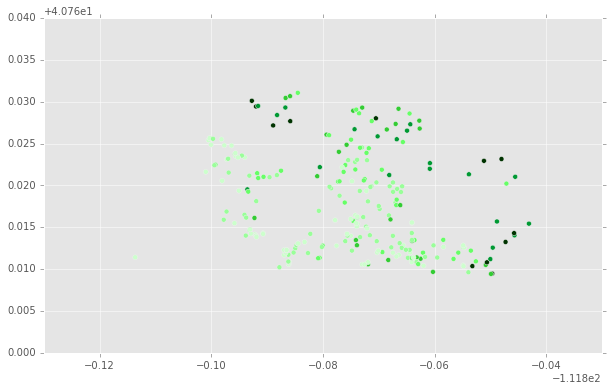

In [56]:
import matplotlib.pyplot as plt2 

# Generate data...
x = housing_data['Longitude']
y = housing_data['Latitude']
c = housing_data['LstPrice']

#colors = numpy.hstack((numpy.zeros_like(z), numpy.zeros_like(z), numpy.ones_like(z), z/z.max()))

colors = pd.cut(housing_data['SoldPrice'], 6, right=True, include_lowest=True, labels=['#ccffcc', '#99ff99', '#66ff66','#33cc33','#009933','#003300'])         
#print(len(colors))
                
                
plt2.scatter(x, y, c=colors, s=25)
plt2.show()


# Geospatial Plot

**Your Interpretation:** 

The scatter plot above has latitude as the y axis and longitude as the x axis. The darker the dot, the more expensive the house. As you can see, houses tend to be more expensive going north and going east, presumably because in the Avenues, these homes are higher up on the hill and offer more scenic views.

### Task 1.5 Simple  Linear Regression 
Use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (SoldPrice ~ LstPrice) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a plot of list price vs. sold price and overlay the prediction coming from your regression model. 

259
                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.590e+04
Date:                Sat, 15 Oct 2016   Prob (F-statistic):          5.20e-260
Time:                        22:49:01   Log-Likelihood:                -2916.4
No. Observations:                 259   AIC:                             5837.
Df Residuals:                     257   BIC:                             5844.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    1.31e+04   2965.806      4.415     

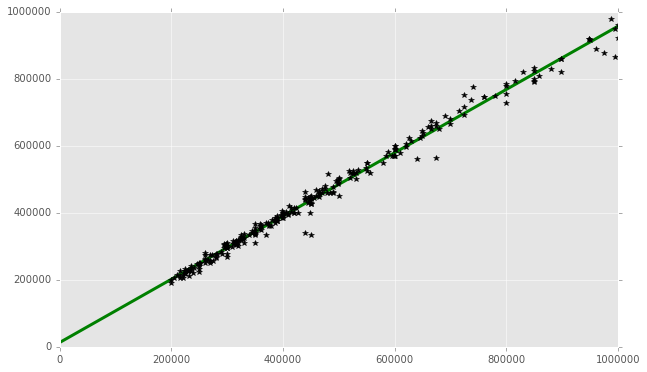

In [53]:
# Your code here

print(housing_data['TotSqf'].count())

from scipy.stats import linregress
from scipy.stats import norm

model = sm.ols(formula="SoldPrice ~ LstPrice", data=housing_data)

# fit the model
model_result = model.fit()

print(model_result.summary())


list_price = housing_data['LstPrice'].tolist()
sold_price = housing_data['SoldPrice'].tolist()

lr_housing_sold = linregress(x=list_price, y=sold_price)

x = sc.linspace(0,max(list_price),1000)
plt.plot(x,lr_housing_sold.intercept + lr_housing_sold.slope*x,'g',linewidth=3)

plt.plot(list_price,sold_price,'k*',label='List VS Sold Regession')

**Your Interpretation:** 

The r-squared variable represents the accuracy of fit between predicted and actual values. Acording to the correlation matrix, the r-squared is .99 which suggests that the sold price is usually very close to the listed price. Beta-1 is represented as 'coef' in the regression chart, and is the slope of the regression line (0.94). As you can tell, the relationship between List Price and Sold Price are positively correlated.

### Task 1.6 Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. Do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables. Which variables are the best predictors for the Sold Price? 

Specific questions:
1. Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.  
+ Estimate the value that each Garage space adds to a house. 
+ Does latitude or longitude have an impact on house price? Explain. 
+ If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

In [57]:
# Your code here

model2 = sm.ols(formula="SoldPrice ~ TotSqf + GaragCap + Longitude + Latitude", data=housing_data)

model2_result = model2.fit()

print(model2_result.summary())


                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     253.1
Date:                Sat, 15 Oct 2016   Prob (F-statistic):           2.46e-87
Time:                        22:50:15   Log-Likelihood:                -3307.0
No. Observations:                 259   AIC:                             6624.
Df Residuals:                     254   BIC:                             6642.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.032e+08   5.12e+07      3.967      0.0

**Your Interpretation:**

1. The coef for TotSqf is not measuring price per square foot per se, since it includes non-usable square footage on the property. And even then, the r-squared relationship is .86 so it wouldn't be a perfect predictor anyway.
2. According to the coefficient, each garage space adds an additional $41,690 to the home's value.
3. Yes, as houses tend to be higher up on the hill in the avenues (north and east) home values end to be more expensive.
4. The multi-linear regression's r-squared value is only .799. The r-squared  value for list price and sold price is .990. Our regression model is NOT a more accurate predictor of the sold price than the list price so I wouldn't go into the house-flipping business with the present model.

### Task 1.7 Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

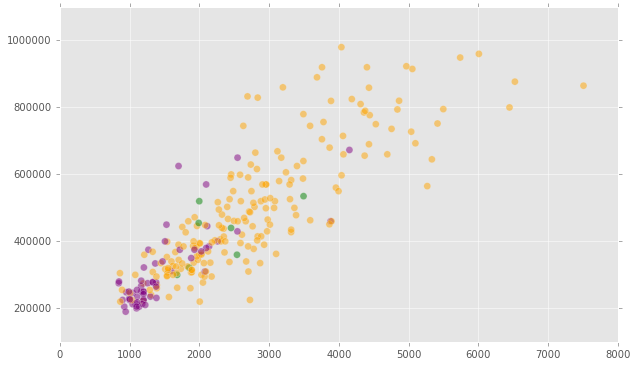

In [55]:
# Associate different property types with different colors

def colorize(prop_type):
    if prop_type == 'Condo':
        return 'purple'
    elif prop_type == 'Townhouse':
        return 'green'
    elif prop_type == 'Single Family':
        return 'orange'
    
#print(housing_data['TotSqf'].count())

colors = housing_data['PropType'].map(colorize)

x = housing_data['TotSqf']
y = housing_data['SoldPrice']

#print(len(x),len(y))
#print(max(x),max(y))


plt2.scatter(x, y, c=colors, s=50, alpha=.5)
plt2.show()

**Your Interpretation:** 

This scatterplot shows how total square feet correlates with the value of the home. x axis = TotSqft, y axis= SoldPrice. Condos are purple, townhouses are green, and single family homes are orange. Single family homes tend to be bigger and more valuable, but it seems that all three of these property types are of similar value when they are of similar size.